# TimeSeries RL Agent Tuning Tutorial

Welcome to the RLTimeSeriesAgent tuning tutorial! This notebook demonstrates how to use the ModelTuner to find the optimal hyperparameters for your TimeSeries RL Agent. The tuner allows you to explore different configurations and automatically train multiple models with varying parameters to find the best performing combination.

This tutorial is divided into three main parts:

1. Setting Up and Configuring the Tuner
2. Running the Hyperparameter Search
3. Training the Final Model with Best Parameters

Let's get started!

## Installation

First, let's install the required packages:

In [1]:
!pip install timeseries-agent --quiet
!pip install lightning torch --quiet

## Part 1: Setting Up and Configuring the Tuner

### 1.1 Import Libraries

Let's start by importing all necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch import seed_everything
seed_everything(42, workers=True)  # sets seeds for numpy, torch and python.random

from timeseries_agent import SequentialTimeSeriesDataset, PolicyGradientAgent
from timeseries_agent.tuning import ModelTuner
from timeseries_agent.data import create_random_walk

Seed set to 42


### 1.2 Create Sample Data

We'll load a sample random walk dataset from the data module:


Random Walk Dataset Shapes:
Train: (750, 2)
Test: (250, 2)


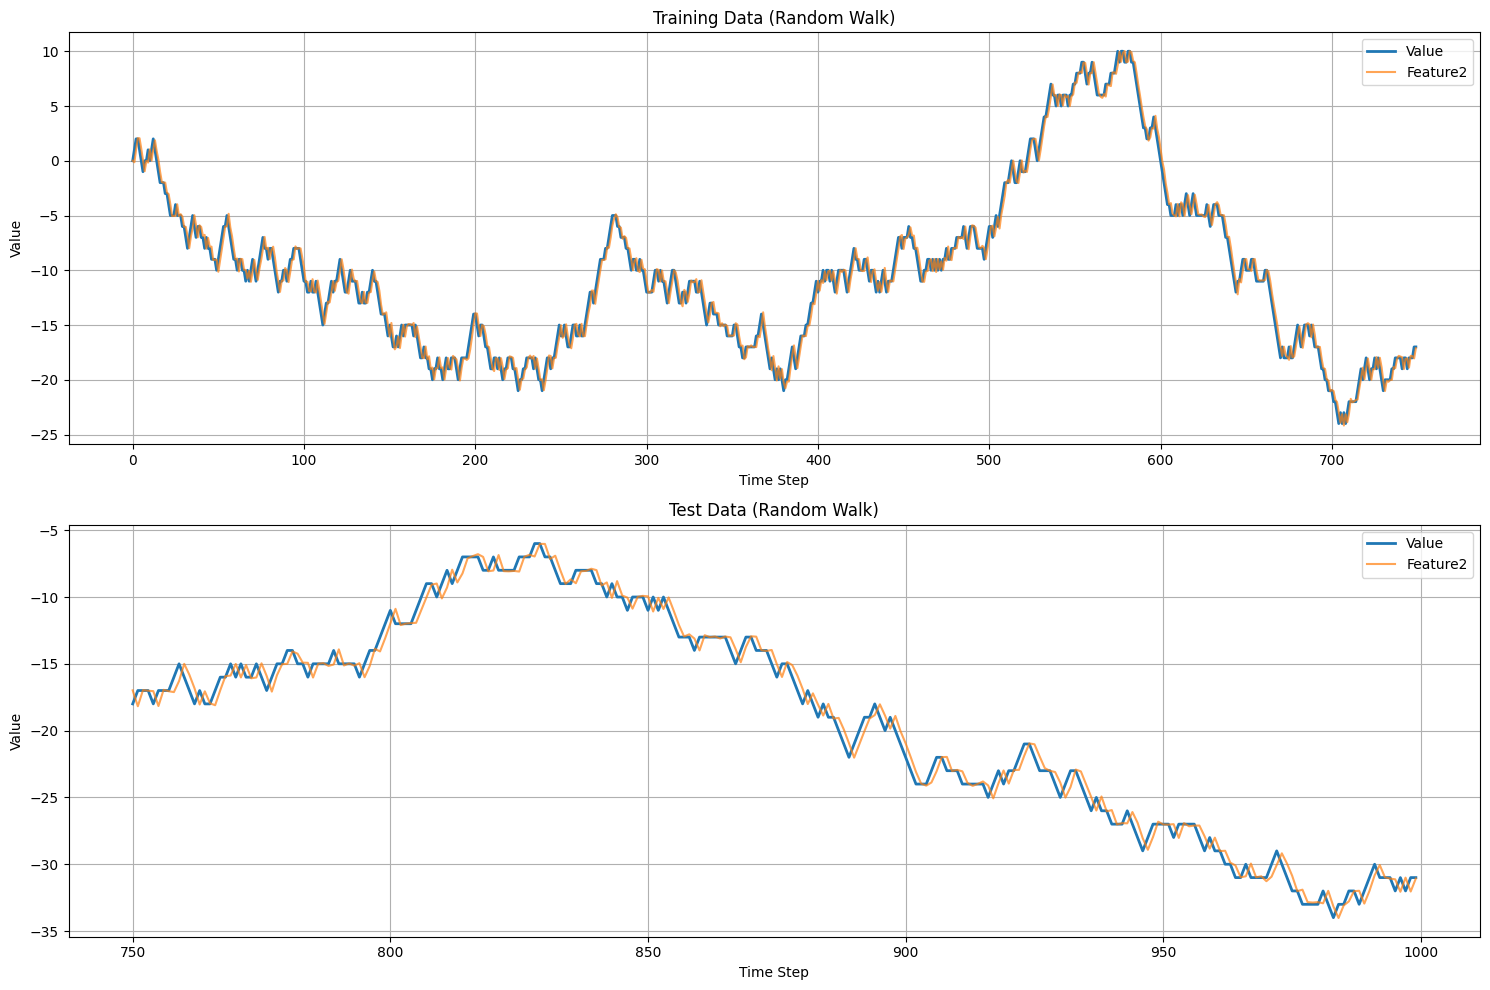

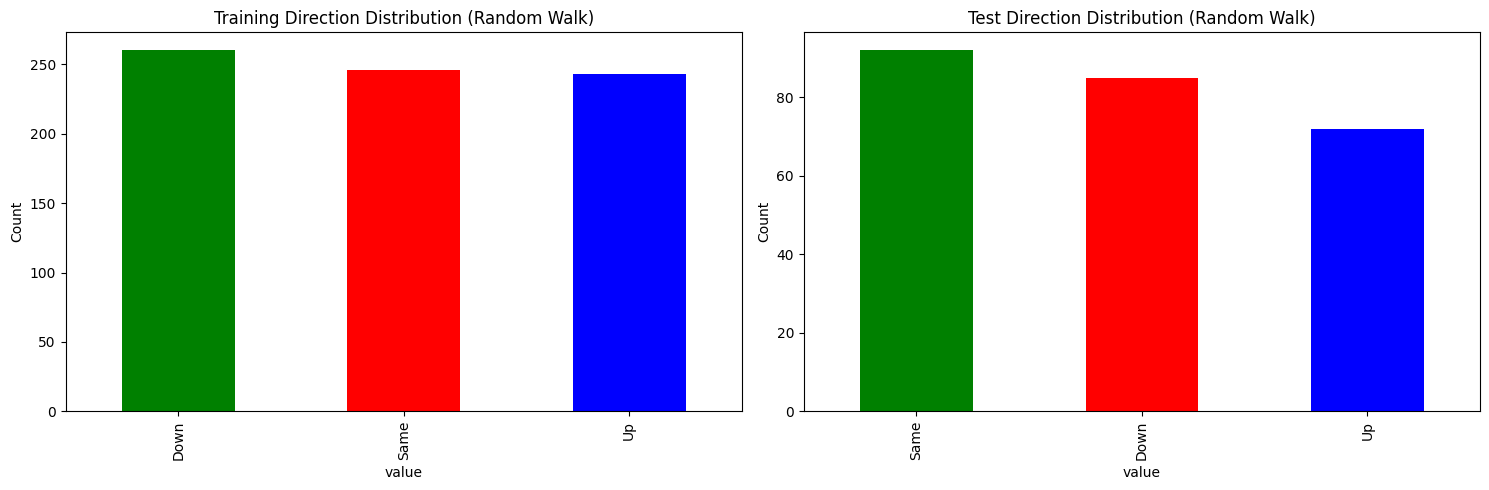

In [4]:
# Create random walk dataset
random_walk_data = create_random_walk(n_steps=1000, step_size=1.0, train_test_split=0.75)
print("\nRandom Walk Dataset Shapes:")
print(f"Train: {random_walk_data.train_df.shape}")
print(f"Test: {random_walk_data.test_df.shape}")

# Visualize random walk data
random_walk_data.plot_series()
random_walk_data.plot_directions()

In [6]:
# Use the training data for the agent
data_df = random_walk_data.train_df.copy()

### 1.3 Define Hyperparameter Search Space

Define the ranges of hyperparameters we want to explore:

In [7]:
# Hyperparameter ranges to test
param_ranges = {
    'learning_rate': [0.001, 0.0005],           # Different learning rates
    'lookback': [5, 7],                         # Different lookback periods
    'hidden_layers': [
        [100, 100, 10],                         # Network configuration 1
        [200, 100, 50],                         # Network configuration 2
    ],
    'epsilon_start': [1.0, 0.9],               # Different exploration start rates
    'epsilon_end': [0.01, 0.05],               # Different exploration end rates
    'epsilon_decay_epochs_rate': [0.4, 0.6],   # Different decay rates 
}

# Base parameters that will be the same for all models
base_params = {
    'normalize_state': True,            # Normalize input states
    'eval_noise_factor': 0.1,           # Add noise during evaluation
    'num_training_epochs': 10,          # Number of training epochs
}

print("\nHyperparameter Search Space:")
for param, values in param_ranges.items():
    print(f"{param}: {values}")

# Total number of models to be trained
num_models = np.prod([len(v) for v in param_ranges.values()])
print(f"\nTotal number of models to be trained: {num_models}")

print("\nBase Parameters:")
for param, value in base_params.items():
    print(f"{param}: {value}")


Hyperparameter Search Space:
learning_rate: [0.001, 0.0005]
lookback: [5, 7]
hidden_layers: [[100, 100, 10], [200, 100, 50]]
epsilon_start: [1.0, 0.9]
epsilon_end: [0.01, 0.05]
epsilon_decay_epochs_rate: [0.4, 0.6]

Total number of models to be trained: 64

Base Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_training_epochs: 10


## Part 2: Running the Hyperparameter Search

### 2.1 Initialize and Run the Tuner

Create the ModelTuner and start the hyperparameter search:

In [8]:
# Create tuner instance
tuner = ModelTuner(
    data_df=data_df,
    base_log_dir="logs",
    target_column="value",
)

# Train models with different hyperparameter combinations
print("\nStarting hyperparameter search...")
results = tuner.train(
    param_ranges=param_ranges,
    num_epochs=base_params['num_training_epochs'],
    base_params=base_params,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the


Starting hyperparameter search...

Training model 1/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_reward=-0.347, train_loss=-0.367, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_reward=-0.347, train_loss=-0.367, epsilon=0.010]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.42473119497299194
   val_pass_percentage       28.76344108581543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 2/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=0, train_reward=-0.325, train_loss=-0.228, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.8951612710952759
   val_pass_percentage      5.2419352531433105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 3/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.78it/s, v_num=0, train_reward=-0.363, train_loss=-0.228, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4838709533214569
   val_pass_percentage       25.80645179748535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 4/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.77it/s, v_num=0, train_reward=-0.347, train_loss=-0.25, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.059139784425497055
   val_pass_percentage       47.04301071166992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 5/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.336, train_loss=-0.233, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4973118305206299
   val_pass_percentage      25.134408950805664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 6/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.78it/s, v_num=0, train_reward=-0.315, train_loss=-0.333, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.07795698940753937
   val_pass_percentage      46.102149963378906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 7/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.76it/s, v_num=0, train_reward=-0.312, train_loss=-0.317, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5403226017951965
   val_pass_percentage      22.983871459960938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 8/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.78it/s, v_num=0, train_reward=-0.36, train_loss=-0.243, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.24731183052062988
   val_pass_percentage       37.63440704345703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 9/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.61it/s, v_num=0, train_reward=-0.282, train_loss=-0.133, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.15860214829444885
   val_pass_percentage       42.06989288330078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 10/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_reward=-0.398, train_loss=-0.0468, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4301075339317322
   val_pass_percentage       28.4946231842041
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 11/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.336, train_loss=-0.251, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        0.032258063554763794
   val_pass_percentage       51.6129035949707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 12/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.312, train_loss=-0.322, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.448924720287323
   val_pass_percentage       27.55376434326172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 13/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.304, train_loss=-0.209, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.23924730718135834
   val_pass_percentage      38.037635803222656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 14/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_reward=-0.331, train_loss=-0.145, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.10483870655298233
   val_pass_percentage       44.75806427001953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 15/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_reward=-0.384, train_loss=-0.30, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.49462366104125977
   val_pass_percentage      25.268817901611328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 16/64
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_reward=-0.301, train_loss=-0.285, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.17473118007183075
   val_pass_percentage       41.2634391784668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 17/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.72it/s, v_num=0, train_reward=-0.321, train_loss=-0.347, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.05121293663978577
   val_pass_percentage       47.43935775756836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 18/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_reward=-0.348, train_loss=-0.374, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.04043126851320267
   val_pass_percentage       47.97843551635742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 19/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.305, train_loss=-0.161, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5175201892852783
   val_pass_percentage      24.123987197875977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 20/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=0, train_reward=-0.272, train_loss=-0.112, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.42318055033683777
   val_pass_percentage      28.840970993041992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 21/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_reward=-0.288, train_loss=-0.311, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4743935465812683
   val_pass_percentage       26.28032112121582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 22/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_reward=-0.302, train_loss=-0.20, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.12668463587760925
   val_pass_percentage      43.665767669677734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 23/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.326, train_loss=-0.346, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.44474393129348755
   val_pass_percentage       27.76280403137207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 24/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_reward=-0.337, train_loss=-0.358, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3989218473434448
   val_pass_percentage      30.053909301757812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 25/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_reward=-0.299, train_loss=-0.107, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4150943458080292
   val_pass_percentage      29.245285034179688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 26/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.275, train_loss=0.00414, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4474393129348755
   val_pass_percentage      27.628032684326172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 27/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s, v_num=0, train_reward=-0.353, train_loss=-0.332, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.05929919332265854
   val_pass_percentage       47.03504180908203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 28/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_reward=-0.342, train_loss=-0.214, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4474393129348755
   val_pass_percentage      27.628032684326172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 29/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.34, train_loss=-0.0906, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.506738543510437
   val_pass_percentage      24.663070678710938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 30/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.28, train_loss=-0.0463, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.04043126851320267
   val_pass_percentage       47.97843551635742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 31/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=0, train_reward=-0.315, train_loss=-0.361, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5040431022644043
   val_pass_percentage       24.7978458404541
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 32/64
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=0, train_reward=-0.334, train_loss=-0.37, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.08355794847011566
   val_pass_percentage       45.82210159301758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 33/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_reward=-0.258, train_loss=-0.0988, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5026881694793701
   val_pass_percentage      24.865591049194336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 34/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_reward=-0.274, train_loss=-0.301, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.37365591526031494
   val_pass_percentage      31.317203521728516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 35/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.72it/s, v_num=0, train_reward=-0.317, train_loss=-0.332, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.16129031777381897
   val_pass_percentage      41.935482025146484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 36/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=0, train_reward=-0.317, train_loss=-0.337, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.22043010592460632
   val_pass_percentage      38.978492736816406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 37/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.78it/s, v_num=0, train_reward=-0.282, train_loss=-0.306, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.10752688348293304
   val_pass_percentage       44.6236572265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 38/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=0, train_reward=-0.376, train_loss=-0.405, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4220430254936218
   val_pass_percentage      28.897850036621094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 39/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=0, train_reward=-0.328, train_loss=-0.165, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.04838709533214569
   val_pass_percentage       47.58064651489258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 40/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=0, train_reward=-0.368, train_loss=-0.217, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.12903225421905518
   val_pass_percentage       43.54838562011719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 41/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_reward=-0.344, train_loss=-0.242, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5403226017951965
   val_pass_percentage      22.983871459960938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 42/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_reward=-0.331, train_loss=-0.0902, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        0.029569892212748528
   val_pass_percentage      51.478492736816406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 43/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_reward=-0.304, train_loss=-0.166, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.09139785170555115
   val_pass_percentage       45.43010711669922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 44/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_reward=-0.298, train_loss=-0.204, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.42741936445236206
   val_pass_percentage      28.629032135009766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 45/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.32, train_loss=-0.163, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.09408602118492126
   val_pass_percentage       45.29570007324219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 46/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_reward=-0.328, train_loss=0.031, epsilon=0.010]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.02150537632405758
   val_pass_percentage       48.92473220825195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 47/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=0, train_reward=-0.379, train_loss=-0.443, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.07526881992816925
   val_pass_percentage       46.2365608215332
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 48/64
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_reward=-0.306, train_loss=-0.0344, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.45698925852775574
   val_pass_percentage      27.150537490844727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 49/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_reward=-0.294, train_loss=-0.332, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.1320754736661911
   val_pass_percentage       43.39622497558594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 50/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.61it/s, v_num=0, train_reward=-0.28, train_loss=-0.129, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.33423179388046265
   val_pass_percentage       33.28841018676758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 51/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.68it/s, v_num=0, train_reward=-0.302, train_loss=-0.357, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.12668463587760925
   val_pass_percentage      43.665767669677734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 52/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.79it/s, v_num=0, train_reward=-0.275, train_loss=-0.316, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.2075471729040146
   val_pass_percentage      39.622642517089844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 53/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.77it/s, v_num=0, train_reward=-0.296, train_loss=-0.333, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.32345014810562134
   val_pass_percentage      33.827491760253906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 54/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.315, train_loss=-0.121, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.15094339847564697
   val_pass_percentage       42.45283126831055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 55/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=0, train_reward=-0.305, train_loss=-0.343, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3827493190765381
   val_pass_percentage       30.86253547668457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 56/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=0, train_reward=-0.251, train_loss=-0.0678, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4474393129348755
   val_pass_percentage      27.628032684326172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 57/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.72it/s, v_num=0, train_reward=-0.253, train_loss=-0.0342, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5121293663978577
   val_pass_percentage      24.393531799316406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 58/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_reward=-0.264, train_loss=-0.0886, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5498652458190918
   val_pass_percentage      22.506736755371094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 59/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s, v_num=0, train_reward=-0.323, train_loss=-0.161, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4366576671600342
   val_pass_percentage      28.167116165161133
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 60/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.63it/s, v_num=0, train_reward=-0.337, train_loss=-0.17, epsilon=0.050]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.49865230917930603
   val_pass_percentage      25.067384719848633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 61/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=0, train_reward=-0.294, train_loss=-0.0358, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.47978436946868896
   val_pass_percentage       26.01078224182129
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 62/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_reward=-0.237, train_loss=-0.0907, epsilon=0.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5121293663978577
   val_pass_percentage      24.393531799316406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 63/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.62it/s, v_num=0, train_reward=-0.302, train_loss=-0.302, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4609164297580719
   val_pass_percentage      26.954179763793945
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Training model 64/64
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 28.3 K | train
-----------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_reward=-0.329, train_loss=-0.391, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.43396225571632385
   val_pass_percentage       28.30188751220703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Tuning results saved to: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\tuning_results_v0.csv


### 2.2 Analyze Tuning Results

Let's examine the results of our hyperparameter search:

In [10]:
print("\nTuning Results (sorted by validation reward):")
print(results)

# Get best performing model details
best_model = results.iloc[0]
print("\nBest Model Configuration:")
for param, value in best_model.items():
    print(f"{param}: {value}")

print(f"\nBest model checkpoint saved at: {best_model['model_dir']}")


Tuning Results (sorted by validation reward):
    learning_rate  lookback   hidden_layers  epsilon_start  epsilon_end  \
10         0.0010         5  [200, 100, 50]            1.0         0.05   
41         0.0005         5  [200, 100, 50]            1.0         0.01   
45         0.0005         5  [200, 100, 50]            0.9         0.01   
17         0.0010         7  [100, 100, 10]            1.0         0.01   
29         0.0010         7  [200, 100, 50]            0.9         0.01   
..            ...       ...             ...            ...          ...   
18         0.0010         7  [100, 100, 10]            1.0         0.05   
40         0.0005         5  [200, 100, 50]            1.0         0.01   
6          0.0010         5  [100, 100, 10]            0.9         0.05   
57         0.0005         7  [200, 100, 50]            1.0         0.01   
1          0.0010         5  [100, 100, 10]            1.0         0.01   

    epsilon_decay_epochs_rate  val_avg_reward  val_p

## Part 3: Training Final Model with Best Parameters

### 3.1 Setup Final Training

Extract and prepare the best parameters for final training:

In [26]:
# Extract best hyperparameters
best_params = {
    'learning_rate': best_model['learning_rate'],
    'lookback': best_model['lookback'],
    'hidden_layers': best_model['hidden_layers'],
    'epsilon_start': best_model['epsilon_start'],
    'epsilon_end': best_model['epsilon_end'],
    'epsilon_decay_epochs_rate': best_model['epsilon_decay_epochs_rate'],
}

# Set the number of training epochs for final training
# Note: Best decay rate will be used on the num_training_epochs
base_params['num_training_epochs'] = 10        

# Combine with base parameters
final_params = {**base_params, **best_params}

print("\nFinal Training Parameters:")
for param, value in final_params.items():
    print(f"{param}: {value}")


Final Training Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_training_epochs: 10
learning_rate: 0.001
lookback: 5
hidden_layers: [200, 100, 50]
epsilon_start: 1.0
epsilon_end: 0.05
epsilon_decay_epochs_rate: 0.4


### 3.2 Train Final Model

Train a new model using the best parameters:

In [28]:
# Create dataset
final_dataset = SequentialTimeSeriesDataset(
    data=data_df,
    lookback=best_params['lookback'],
)
dataloader = DataLoader(final_dataset, batch_size=len(final_dataset), shuffle=False, num_workers=0)

# Create agent with best parameters
agent = PolicyGradientAgent(
    full_data=data_df,
    target_column="value",
    input_features=data_df.shape[1],
    output_size=3,
    **final_params
)

# Setup trainer
trainer = L.Trainer(
    max_epochs=base_params['num_training_epochs'], # Number of epochs for final training
    accelerator='auto',
    devices='auto',
    log_every_n_steps=1,
    enable_checkpointing=True,
    logger=L.pytorch.loggers.CSVLogger("logs", name="tuning_final_model"),
    deterministic=True,
)

print("\nTraining final model with best parameters...")
trainer.fit(agent, dataloader)
print("\nTraining finished.")

print("\nEvaluating final model...")
trainer.validate(model=agent, dataloaders=dataloader)
print("Evaluation finished.")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Training final model with best parameters...
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=6, train_reward=-0.298, train_loss=-0.337, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=6, train_reward=-0.298, train_loss=-0.337, epsilon=0.050]

Training finished.

Evaluating final model...
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.06451612710952759
   val_pass_percentage      46.774192810058594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Evaluation finished.


### 3.3 Save and Visualize Results

Save the final model and plot the training progress:

Final model saved to: logs\tuning_final_model\version_6\final_model.ckpt


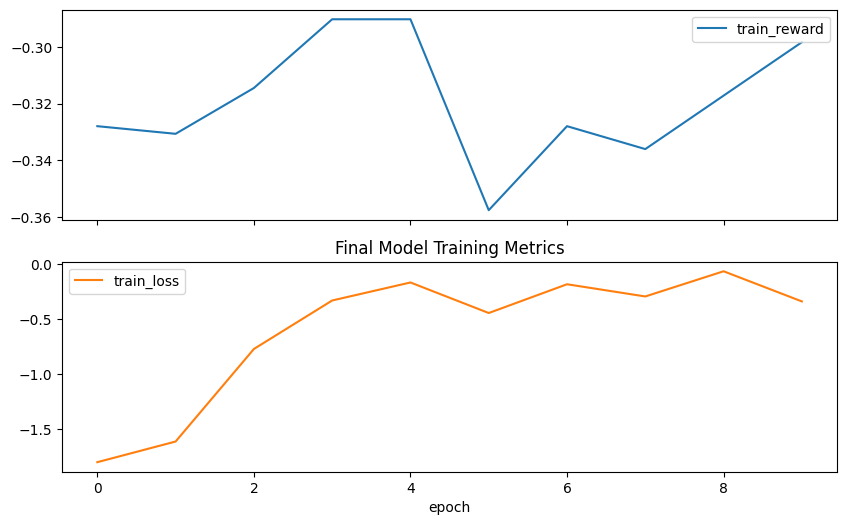

In [29]:
# Save the model
model_dir = trainer.logger.log_dir
trainer.save_checkpoint(os.path.join(model_dir, "final_model.ckpt"))
print(f"Final model saved to: {os.path.join(model_dir, 'final_model.ckpt')}")

# Plot training logs
logs = pd.read_csv(os.path.join(model_dir, "metrics.csv"))
logs.set_index('epoch', inplace=True)
logs[['train_reward', 'train_loss']].plot(subplots=True, figsize=(10, 6))
plt.title("Final Model Training Metrics")
plt.savefig(os.path.join(model_dir, "training_metrics.png"))
plt.show()